##### Install Libraries

* Please uncomment the code below to install Pytorch before running this notebook first time in the new environment.

In [1]:
# !pip install torch

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import Capstone_Utilities as utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random

### Loading ML dataset

In [3]:
datafile_name = 'Capstone_final_dataset_for_ml_50ms.csv'
data = pd.read_csv(datafile_name,index_col=0)
print('dataset for ML:',data.shape)
data.head()

dataset for ML: (718277, 87)


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,1


#### Convert/map labels from 0 to 3 
* PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0
* Labels in the Dataset are:1 for Baseline, 2 for Stress, 3 for Amusement and 4 for Meditation

In [4]:
print(data.label.unique())

[1 2 3 4]


In [5]:
class2idx = {1:0,2:1,3:2,4:3}

idx2class = {v: k for k, v in class2idx.items()}

data['label'].replace(class2idx, inplace=True)

print(data.label.unique())

data.head()

[0 1 2 3]


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms,label
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939,0


In [6]:
# Create dataset for Model
X_data = data.iloc[:,0:-1]
y_data = data.iloc[:,-1]

print('X_data.shape:',X_data.shape)
print('Y_data.shape:',y_data.shape)
display(X_data.head())

X_data.shape: (718277, 86)
Y_data.shape: (718277,)


,ACC_1,ACC_2,ACC_3,ECG,EMG,EDA,Temp,Resp,age,height,...,tonic_energy,tonic_peaks,tonic_rms,phasic_mean,phasic_std,phasic_min,phasic_max,phasic_energy,phasic_peaks,phasic_rms
0,0.889131,-0.104177,-0.254086,0.052203,0.000302,5.712509,29.119919,1.025521,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
1,0.889731,-0.100206,-0.242897,0.076138,-0.005188,5.707354,29.119755,0.710013,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
2,0.893480,-0.103223,-0.248234,0.073135,-0.003722,5.698667,29.125584,0.327802,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
3,0.878366,-0.113154,-0.236754,0.054067,0.000221,5.692651,29.133441,-0.066877,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939
4,0.890411,-0.117394,-0.238989,0.058294,-0.003258,5.685992,29.122919,-0.490505,27.0,175.0,...,1.050443e+08,27.0,12.093175,7.010534,12.596496,0.0,85.473764,1.492718e+08,41.0,14.415939


##### Split data into train, validate and test sets

In [7]:
X_train,X_val,X_test,y_train,y_val,y_test = utility.split_data(X_data,y_data)

print('Traing Shape:',X_train.shape,y_train.shape)
print('Validation Shape:',X_val.shape,y_val.shape)
print('Testing Shape:',X_test.shape,y_test.shape)

Traing Shape: (574621, 86) (574621,)
Validation Shape: (71828, 86) (71828,)
Testing Shape: (71828, 86) (71828,)


##### Normalize Data

In [8]:
# Scale dataset before applying machine learning
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

##### Visualize class distribution in train, val and test dataset

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "baseline_1": 0,
        "stess_2": 0,
        "amusement_3": 0,
        "meditation_4": 0
    }
    for i in obj:
        if i == 0: 
            count_dict['baseline_1'] += 1
        elif i == 1: 
            count_dict['stess_2'] += 1
        elif i == 2: 
            count_dict['amusement_3'] += 1
        elif i == 3: 
            count_dict['meditation_4'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

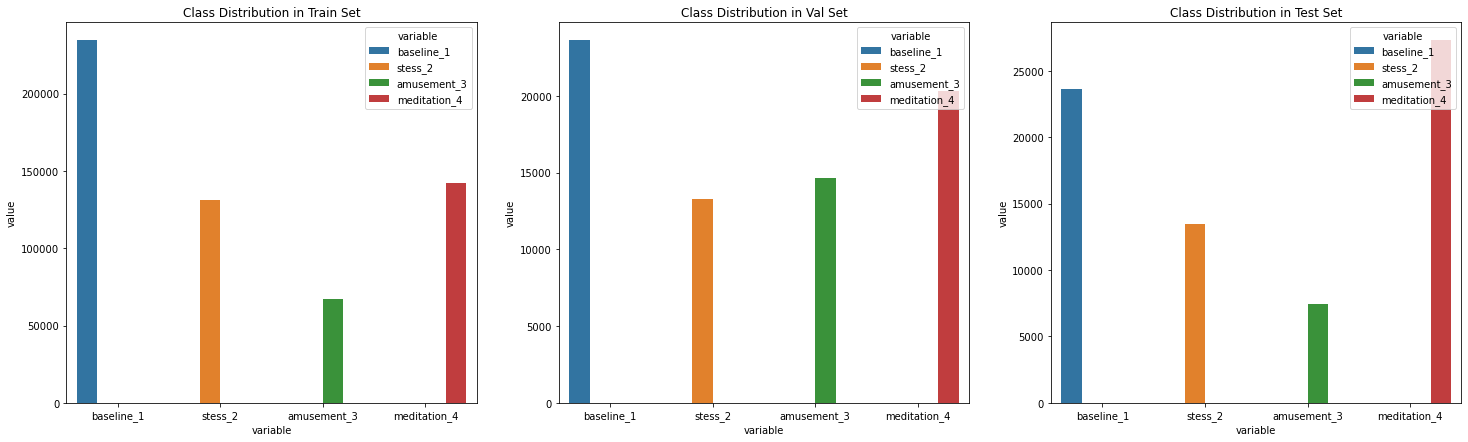

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')
plt.show()

### Neural Network Modeling

#### Sensor Dataset
This dataset will be used by the dataloader to pass the data into model. The X values need to in float while y values need to be in long format.

In [11]:
class SensorDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        x,y = self.X_data[index], self.y_data[index]
        return x,y
    
    def __len__ (self):
        return len(self.X_data)

train_dataset = SensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = SensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = SensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

##### Weighted Sampling

As it is observed in the graph above that there is a class imbalance, and even though stratified split was used but still it does not ensure that each mini-batch of the model gets representation from all the classes.

We need to over-sample the classes with less number of values using WeightedRandomSampler.

In [12]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
print('Target list length:',len(target_list))

Target list length: 574621


In [13]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([4.2679e-06, 7.6389e-06, 1.4880e-05, 7.0325e-06])


In [14]:
# assign weight for each sample
class_weights_all = class_weights[target_list]

In [15]:
# Initialize weighted Random Sampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

#### Model Parameters

In [16]:
EPOCHS = 25
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X_data.columns)
NUM_CLASSES = 4 # four effective states label

##### Dataloader
* batch_size = 64  for training
* batch_size = 1 for test and val dataset

In [17]:
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=weighted_sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)

##### Neural Network Architecture

* A simple 3-layer feed-forward network with dropout and batch-norm.

In [18]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)  
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Initialize Model, Optimizer and Loss Function

* Using the nn.CrossEntropyLoss because this is a multiclass classification problem. 
* No need to apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. However, we need to apply log_softmax for our validation and testing.

In [20]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=86, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


##### Model Training

##### Calculate Accuracy
This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [21]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [22]:
# store accuracy and loss
accuracy_stats = { 'train': [],"val": [] }
loss_stats = {'train': [],"val": [] }

##### Begin Training

In [23]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.11392 | Val Loss: 6.90082 | Train Acc: 95.662 | Val Acc: 27.346
Epoch 002: | Train Loss: 0.01580 | Val Loss: 9.79956 | Train Acc: 99.399 | Val Acc: 25.395
Epoch 003: | Train Loss: 0.01031 | Val Loss: 14.02043 | Train Acc: 99.588 | Val Acc: 25.834
Epoch 004: | Train Loss: 0.00864 | Val Loss: 16.95834 | Train Acc: 99.659 | Val Acc: 28.210
Epoch 005: | Train Loss: 0.00713 | Val Loss: 17.38408 | Train Acc: 99.709 | Val Acc: 28.213
Epoch 006: | Train Loss: 0.00582 | Val Loss: 18.82058 | Train Acc: 99.753 | Val Acc: 27.919
Epoch 007: | Train Loss: 0.00546 | Val Loss: 21.42579 | Train Acc: 99.769 | Val Acc: 22.036
Epoch 008: | Train Loss: 0.00474 | Val Loss: 20.15676 | Train Acc: 99.799 | Val Acc: 27.292
Epoch 009: | Train Loss: 0.00451 | Val Loss: 24.24868 | Train Acc: 99.807 | Val Acc: 26.925
Epoch 010: | Train Loss: 0.00432 | Val Loss: 22.11852 | Train Acc: 99.810 | Val Acc: 27.296
Epoch 011: | Train Loss: 0.00378 | Val Loss: 23.43387 | Train Acc: 99.829 | Val Ac

##### Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

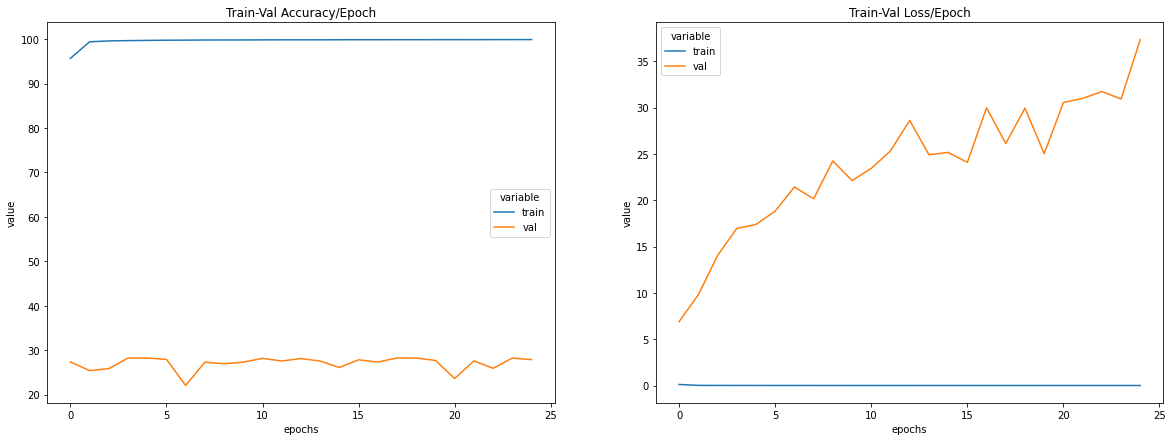

In [24]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

##### Test the Model

In [26]:
y_pred_list = []
y_test_target_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_test_target in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_target_list.append(y_test_target.to(device))
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

##### Confusion Matrix

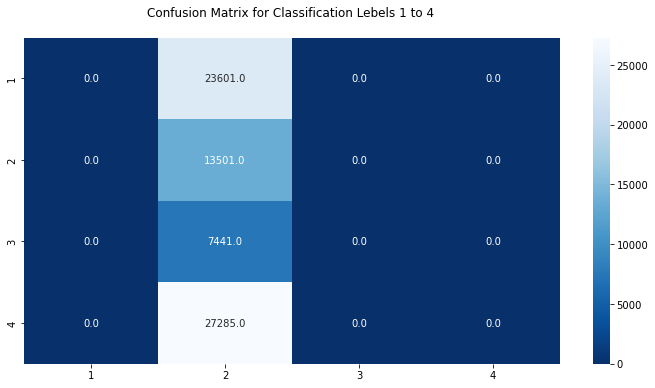

In [33]:
plt.figure(figsize=(12, 6))
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True,fmt=".1f",.;)' jy' lpt
plt.title('Confusion Matrix for Classification Lebels 1 to 4 \n')
plt.show()

##### Classification Report

In [34]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23601
           1       0.19      1.00      0.32     13501
           2       0.00      0.00      0.00      7441
           3       0.00      0.00      0.00     27285

    accuracy                           0.19     71828
   macro avg       0.05      0.25      0.08     71828
weighted avg       0.04      0.19      0.06     71828



##### Model Hyper Parameters

In [35]:
EPOCHS = 30
BATCH_SIZE = [8,32,64,128]
LEARNING_RATE = [0.0001,0.001,0.01]
NUM_FEATURES = len(X_data.columns)
NUM_CLASSES = 4 # four effective states label

In [36]:
def best_nn_parameters_training_data(train_dataset,val_dataset):
    for learning_rate in LEARNING_RATE:
        for batch_size in BATCH_SIZE:
            
            # initialize model
            model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
            model.to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            # get train, val and test loader
            train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,sampler=weighted_sampler)
            val_loader = DataLoader(dataset=val_dataset, batch_size=1)
            test_loader = DataLoader(dataset=test_dataset, batch_size=1)
            
            print("++++++++++ Begin training.++++++++++++++++++")
            print('Learning Rate: {} Batch Size: {}'.format(learning_rate,batch_size))
                    
            for e in tqdm(range(1, EPOCHS+1)):
    
                # TRAINING
                train_epoch_loss = 0
                train_epoch_acc = 0
                model.train()
                for X_train_batch, y_train_batch in train_loader:
                    
                    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
                    optimizer.zero_grad()
        
                    y_train_pred = model(X_train_batch)
        
                    train_loss = criterion(y_train_pred, y_train_batch)
                    train_acc = multi_acc(y_train_pred, y_train_batch)
        
                    train_loss.backward()
                    optimizer.step()
        
                    train_epoch_loss += train_loss.item()
                    train_epoch_acc += train_acc.item()
        
        
                # VALIDATION    
                with torch.no_grad():
        
                    val_epoch_loss = 0
                    val_epoch_acc = 0
        
                    model.eval()
                    for X_val_batch, y_val_batch in val_loader:
                        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                        y_val_pred = model(X_val_batch)
                        val_loss = criterion(y_val_pred, y_val_batch)
                        val_acc = multi_acc(y_val_pred, y_val_batch)
                        val_epoch_loss += val_loss.item()
                        val_epoch_acc += val_acc.item()
    
                loss_stats['train'].append(train_epoch_loss/len(train_loader))
                loss_stats['val'].append(val_epoch_loss/len(val_loader))
                accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
                accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
            
            
                print(f'Epoch {e+0:03}:| Train Loss: {train_epoch_loss/len(train_loader):.5f}| Val Loss: {val_epoch_loss/len(val_loader):.5f}| Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

In [ ]:
best_nn_parameters_training_data(train_dataset,val_dataset)

++++++++++ Begin training.++++++++++++++++++
Learning Rate: 0.0001 Batch Size: 8


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.26125| Val Loss: 10.28359| Train Acc: 90.181| Val Acc: 33.392
Epoch 002:| Train Loss: 0.09598| Val Loss: 13.73266| Train Acc: 96.976| Val Acc: 27.534
Epoch 003:| Train Loss: 0.06971| Val Loss: 18.49852| Train Acc: 97.843| Val Acc: 26.518
Epoch 004:| Train Loss: 0.05770| Val Loss: 14.70882| Train Acc: 98.273| Val Acc: 31.833
Epoch 005:| Train Loss: 0.04976| Val Loss: 22.47841| Train Acc: 98.548| Val Acc: 20.161
Epoch 006:| Train Loss: 0.04520| Val Loss: 25.48336| Train Acc: 98.689| Val Acc: 33.743
Epoch 007:| Train Loss: 0.04135| Val Loss: 23.17573| Train Acc: 98.790| Val Acc: 25.771
Epoch 008:| Train Loss: 0.03745| Val Loss: 24.21984| Train Acc: 98.906| Val Acc: 32.373
Epoch 009:| Train Loss: 0.03580| Val Loss: 24.76572| Train Acc: 98.977| Val Acc: 33.653
Epoch 010:| Train Loss: 0.03453| Val Loss: 30.00693| Train Acc: 99.023| Val Acc: 34.436
Epoch 011:| Train Loss: 0.03203| Val Loss: 19.88232| Train Acc: 99.082| Val Acc: 34.347
Epoch 012:| Train Loss: 0.03288|

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.12051| Val Loss: 8.08593| Train Acc: 95.509| Val Acc: 31.885
Epoch 002:| Train Loss: 0.02476| Val Loss: 12.73228| Train Acc: 99.218| Val Acc: 21.709
Epoch 003:| Train Loss: 0.01619| Val Loss: 11.22532| Train Acc: 99.478| Val Acc: 41.294
Epoch 004:| Train Loss: 0.01291| Val Loss: 13.67348| Train Acc: 99.584| Val Acc: 33.405
Epoch 005:| Train Loss: 0.01020| Val Loss: 14.99515| Train Acc: 99.666| Val Acc: 27.648
Epoch 006:| Train Loss: 0.00892| Val Loss: 18.03015| Train Acc: 99.698| Val Acc: 34.418
Epoch 007:| Train Loss: 0.00806| Val Loss: 22.53707| Train Acc: 99.730| Val Acc: 22.060
Epoch 008:| Train Loss: 0.00719| Val Loss: 17.27992| Train Acc: 99.754| Val Acc: 31.457
Epoch 009:| Train Loss: 0.00653| Val Loss: 21.05456| Train Acc: 99.774| Val Acc: 27.839
Epoch 010:| Train Loss: 0.00667| Val Loss: 24.67024| Train Acc: 99.781| Val Acc: 26.960
Epoch 011:| Train Loss: 0.00598| Val Loss: 20.83202| Train Acc: 99.802| Val Acc: 46.616
Epoch 012:| Train Loss: 0.00562| 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.11313| Val Loss: 7.14739| Train Acc: 95.690| Val Acc: 34.427
Epoch 002:| Train Loss: 0.01598| Val Loss: 9.72040| Train Acc: 99.404| Val Acc: 31.832
Epoch 003:| Train Loss: 0.01082| Val Loss: 13.55631| Train Acc: 99.568| Val Acc: 25.196
Epoch 004:| Train Loss: 0.00801| Val Loss: 14.35293| Train Acc: 99.676| Val Acc: 28.009
Epoch 005:| Train Loss: 0.00681| Val Loss: 15.04252| Train Acc: 99.724| Val Acc: 42.804
Epoch 006:| Train Loss: 0.00635| Val Loss: 17.39884| Train Acc: 99.740| Val Acc: 27.351
Epoch 007:| Train Loss: 0.00522| Val Loss: 18.53160| Train Acc: 99.771| Val Acc: 27.386
Epoch 008:| Train Loss: 0.00474| Val Loss: 21.40074| Train Acc: 99.803| Val Acc: 27.711
Epoch 009:| Train Loss: 0.00446| Val Loss: 20.12734| Train Acc: 99.806| Val Acc: 27.649
Epoch 010:| Train Loss: 0.00413| Val Loss: 24.05854| Train Acc: 99.824| Val Acc: 28.194
Epoch 011:| Train Loss: 0.00373| Val Loss: 24.76730| Train Acc: 99.832| Val Acc: 27.126
Epoch 012:| Train Loss: 0.00386| V

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.13509| Val Loss: 5.57115| Train Acc: 95.590| Val Acc: 33.648
Epoch 002:| Train Loss: 0.01207| Val Loss: 8.16830| Train Acc: 99.568| Val Acc: 33.941
Epoch 003:| Train Loss: 0.00908| Val Loss: 12.68143| Train Acc: 99.653| Val Acc: 26.168
Epoch 004:| Train Loss: 0.00657| Val Loss: 13.31448| Train Acc: 99.729| Val Acc: 28.194
Epoch 005:| Train Loss: 0.00633| Val Loss: 12.63307| Train Acc: 99.744| Val Acc: 29.246
Epoch 006:| Train Loss: 0.00526| Val Loss: 14.37641| Train Acc: 99.778| Val Acc: 27.170
Epoch 007:| Train Loss: 0.00421| Val Loss: 16.81791| Train Acc: 99.815| Val Acc: 26.820
Epoch 008:| Train Loss: 0.00412| Val Loss: 19.32072| Train Acc: 99.822| Val Acc: 26.866
Epoch 009:| Train Loss: 0.00347| Val Loss: 15.54797| Train Acc: 99.844| Val Acc: 28.655
Epoch 010:| Train Loss: 0.00350| Val Loss: 21.07119| Train Acc: 99.850| Val Acc: 26.382
Epoch 011:| Train Loss: 0.00320| Val Loss: 19.67310| Train Acc: 99.852| Val Acc: 27.855
Epoch 012:| Train Loss: 0.00283| V

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.25291| Val Loss: 11.39182| Train Acc: 90.800| Val Acc: 33.170
Epoch 002:| Train Loss: 0.11636| Val Loss: 11.34301| Train Acc: 96.399| Val Acc: 28.701
Epoch 003:| Train Loss: 0.08809| Val Loss: 15.02532| Train Acc: 97.326| Val Acc: 23.583
Epoch 004:| Train Loss: 0.07278| Val Loss: 13.16319| Train Acc: 97.850| Val Acc: 28.808
Epoch 005:| Train Loss: 0.06500| Val Loss: 28.72522| Train Acc: 98.129| Val Acc: 33.430
Epoch 006:| Train Loss: 0.05687| Val Loss: 19.03406| Train Acc: 98.362| Val Acc: 31.204
Epoch 007:| Train Loss: 0.05323| Val Loss: 13.71124| Train Acc: 98.475| Val Acc: 28.982
Epoch 008:| Train Loss: 0.04748| Val Loss: 20.87838| Train Acc: 98.661| Val Acc: 34.442
Epoch 009:| Train Loss: 0.04407| Val Loss: 19.35111| Train Acc: 98.772| Val Acc: 33.346
Epoch 010:| Train Loss: 0.04222| Val Loss: 19.62509| Train Acc: 98.807| Val Acc: 34.498
Epoch 011:| Train Loss: 0.03953| Val Loss: 19.52562| Train Acc: 98.905| Val Acc: 34.378
Epoch 012:| Train Loss: 0.03733|

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.08558| Val Loss: 16.60658| Train Acc: 96.846| Val Acc: 25.562
Epoch 002:| Train Loss: 0.02790| Val Loss: 17.38090| Train Acc: 99.098| Val Acc: 26.639
Epoch 003:| Train Loss: 0.01883| Val Loss: 27.37323| Train Acc: 99.392| Val Acc: 27.365
Epoch 004:| Train Loss: 0.01525| Val Loss: 32.41953| Train Acc: 99.505| Val Acc: 27.108
Epoch 005:| Train Loss: 0.01268| Val Loss: 32.30823| Train Acc: 99.602| Val Acc: 27.006
Epoch 006:| Train Loss: 0.01116| Val Loss: 35.25083| Train Acc: 99.646| Val Acc: 27.509
Epoch 007:| Train Loss: 0.00975| Val Loss: 31.45036| Train Acc: 99.690| Val Acc: 27.808
Epoch 008:| Train Loss: 0.01007| Val Loss: 26.79504| Train Acc: 99.693| Val Acc: 26.906
Epoch 009:| Train Loss: 0.00839| Val Loss: 32.12685| Train Acc: 99.730| Val Acc: 27.141
Epoch 010:| Train Loss: 0.00751| Val Loss: 31.36553| Train Acc: 99.749| Val Acc: 24.730
Epoch 011:| Train Loss: 0.00758| Val Loss: 25.52389| Train Acc: 99.755| Val Acc: 27.907
Epoch 012:| Train Loss: 0.00679|

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.06482| Val Loss: 15.37686| Train Acc: 97.398| Val Acc: 27.771
Epoch 002:| Train Loss: 0.01869| Val Loss: 19.96074| Train Acc: 99.259| Val Acc: 25.711
Epoch 003:| Train Loss: 0.01321| Val Loss: 25.26401| Train Acc: 99.484| Val Acc: 25.636
Epoch 004:| Train Loss: 0.01045| Val Loss: 28.02114| Train Acc: 99.583| Val Acc: 25.759
Epoch 005:| Train Loss: 0.00887| Val Loss: 29.86486| Train Acc: 99.651| Val Acc: 26.884
Epoch 006:| Train Loss: 0.00703| Val Loss: 38.21242| Train Acc: 99.707| Val Acc: 24.841
Epoch 007:| Train Loss: 0.00645| Val Loss: 37.07355| Train Acc: 99.733| Val Acc: 27.616
Epoch 008:| Train Loss: 0.00588| Val Loss: 38.07072| Train Acc: 99.755| Val Acc: 27.010
Epoch 009:| Train Loss: 0.00587| Val Loss: 50.37356| Train Acc: 99.770| Val Acc: 27.189
Epoch 010:| Train Loss: 0.00554| Val Loss: 49.78410| Train Acc: 99.758| Val Acc: 27.125
Epoch 011:| Train Loss: 0.00494| Val Loss: 46.09323| Train Acc: 99.802| Val Acc: 25.653
Epoch 012:| Train Loss: 0.00442|

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.05839| Val Loss: 13.75157| Train Acc: 97.622| Val Acc: 25.743
Epoch 002:| Train Loss: 0.01590| Val Loss: 16.49511| Train Acc: 99.385| Val Acc: 25.684
Epoch 003:| Train Loss: 0.01144| Val Loss: 21.82110| Train Acc: 99.566| Val Acc: 25.546
Epoch 004:| Train Loss: 0.00901| Val Loss: 25.53306| Train Acc: 99.629| Val Acc: 25.899
Epoch 005:| Train Loss: 0.00647| Val Loss: 34.35349| Train Acc: 99.720| Val Acc: 24.841
Epoch 006:| Train Loss: 0.00622| Val Loss: 36.25753| Train Acc: 99.737| Val Acc: 26.214
Epoch 007:| Train Loss: 0.00587| Val Loss: 34.92575| Train Acc: 99.758| Val Acc: 25.340
Epoch 008:| Train Loss: 0.00490| Val Loss: 34.39692| Train Acc: 99.786| Val Acc: 28.075
Epoch 009:| Train Loss: 0.00437| Val Loss: 39.44485| Train Acc: 99.813| Val Acc: 27.244
Epoch 010:| Train Loss: 0.00420| Val Loss: 39.67770| Train Acc: 99.819| Val Acc: 27.159
Epoch 011:| Train Loss: 0.00392| Val Loss: 40.30451| Train Acc: 99.826| Val Acc: 27.535
Epoch 012:| Train Loss: 0.00365|

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001:| Train Loss: 0.35013| Val Loss: 13.70260| Train Acc: 86.704| Val Acc: 23.588
Epoch 002:| Train Loss: 0.17975| Val Loss: 14.04639| Train Acc: 94.204| Val Acc: 25.781
Epoch 003:| Train Loss: 0.14269| Val Loss: 10.42567| Train Acc: 95.540| Val Acc: 25.291
Epoch 004:| Train Loss: 0.12001| Val Loss: 13.40708| Train Acc: 96.300| Val Acc: 28.213
Epoch 005:| Train Loss: 0.10835| Val Loss: 11.63030| Train Acc: 96.707| Val Acc: 27.985
Epoch 006:| Train Loss: 0.09714| Val Loss: 20.54278| Train Acc: 97.056| Val Acc: 33.753
Epoch 007:| Train Loss: 0.08852| Val Loss: 17.47196| Train Acc: 97.304| Val Acc: 32.805
Epoch 008:| Train Loss: 0.08372| Val Loss: 8.25832| Train Acc: 97.510| Val Acc: 28.423
Epoch 009:| Train Loss: 0.07715| Val Loss: 14.50626| Train Acc: 97.679| Val Acc: 34.404
Epoch 010:| Train Loss: 0.07451| Val Loss: 20.27769| Train Acc: 97.824| Val Acc: 34.357
Epoch 011:| Train Loss: 0.07097| Val Loss: 16.78807| Train Acc: 97.891| Val Acc: 34.407
Epoch 012:| Train Loss: 0.06727| 